In [5]:
!python -V

Python 3.11.11


In [1]:
import jax
import pennylane as qml
from pennylane import numpy as np
from pennylane import draw
from pennylane import grad
from pennylane.optimize import AdamOptimizer
from pennylane.fourier import circuit_spectrum
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gymnasium as gym
from collections import deque
import random

In [55]:
@qml.qnode(dev)
def actor_qnode(n_qubits, state_input, theta, theta_par):
    # Apply Hadamard
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # RX with state-dependent angle
    for i in range(n_qubits):
        qml.RX(state_input[i], wires=i)
    
    # Entanglement (CZ between neighbours)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    
    # RY with trainable parameter
    for i in range(0, n_qubits):
        qml.RY(theta_par[i], wires=i)
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [56]:
@qml.qnode(dev)
def critic_qnode(n_qubits, critic_input, theta, theta_par):
    # Build same ansatz as above, with critic_input
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RX(critic_input[i], wires=i)

    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

    for i in range(0, n_qubits):
        qml.RY(theta_par[i], wires=i)

    # Q-value output (e.g., Z₀ expectation)
    return [qml.expval(qml.PauliZ(0)) for i in range(n_qubits)]

In [2]:
def make_critic_qnode(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def critic_qnode(critic_input, theta, theta_par):
        # Build same ansatz as above, with critic_input
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.RX(critic_input[i], wires=i)
    
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
    
        for i in range(0, n_qubits):
            qml.RY(theta_par[i], wires=i)
    
        # Q-value output (e.g., Z₀ expectation)
        #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return qml.expval(qml.PauliZ(i))
    return critic_qnode

def make_actor_qnode(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def actor_qnode(state_input, theta, theta_par):
        # Apply Hadamard
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        
        # RX with state-dependent angle
        for i in range(n_qubits):
            qml.RX(state_input[i], wires=i)
        
        # Entanglement (CZ between neighbours)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
        
        # RY with trainable parameter
        for i in range(0, n_qubits):
            qml.RY(theta_par[i], wires=i)
        
        # Measurement
        #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return qml.expval(qml.PauliZ(i))
    return actor_qnode

In [3]:
# TODO: PROPERLY PORT THE QISKIT VERSION TO PENNYLANE
# TODO: IMPORT THE UAV LQDRL GYM ENVIRONMENT TO GET & UPDATE THESE VALUES AFTER EVERY LAYER
m_layers = 3
E_rem = 500e03
num_gus = 4
u = []
uav_pos = [0, 0, 0]
uav_v_max = 30
zeta_v = 1
uav_v = zeta_v * uav_v_max
noma_g = [1, 2, 3]
pwr_alloc = 1
action_vec = []

action_vec.append(uav_v)
for k in range(len(noma_g)):
    action_vec.append(noma_g[k])
action_vec.append(pwr_alloc)

actor_inp_vec = []
crit_inp_vec = []

for i in range(len(uav_pos)):
    actor_inp_vec.append(uav_pos[i])
actor_inp_vec.append(E_rem)
for j in range(2*num_gus):
    u.append(j)
    actor_inp_vec.append(u[j])

full_input = np.concatenate([actor_inp_vec, action_vec])

n_qubits = len(actor_inp_vec)
print(n_qubits) 
n_crit_qubits = len(full_input)
print(n_crit_qubits)

theta = np.zeros(n_qubits, requires_grad=True)
theta_par = np.random.randn(n_qubits, requires_grad=True)

crit_theta = np.zeros(n_crit_qubits, requires_grad=True)
crit_theta_par = np.random.randn(n_crit_qubits, requires_grad=True)

critic_qnode = make_critic_qnode(n_crit_qubits)
#q_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)
q_val = critic_qnode(full_input, crit_theta, crit_theta_par)

actor_qnode = make_actor_qnode(n_qubits)
#q_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)
q_vals = actor_qnode(actor_inp_vec, theta, theta_par)

'''
# Forward pass
q_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)
q_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)
'''

12
17


'\n# Forward pass\nq_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)\nq_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)\n'

(<Figure size 1700x1300 with 1 Axes>, <Axes: >)

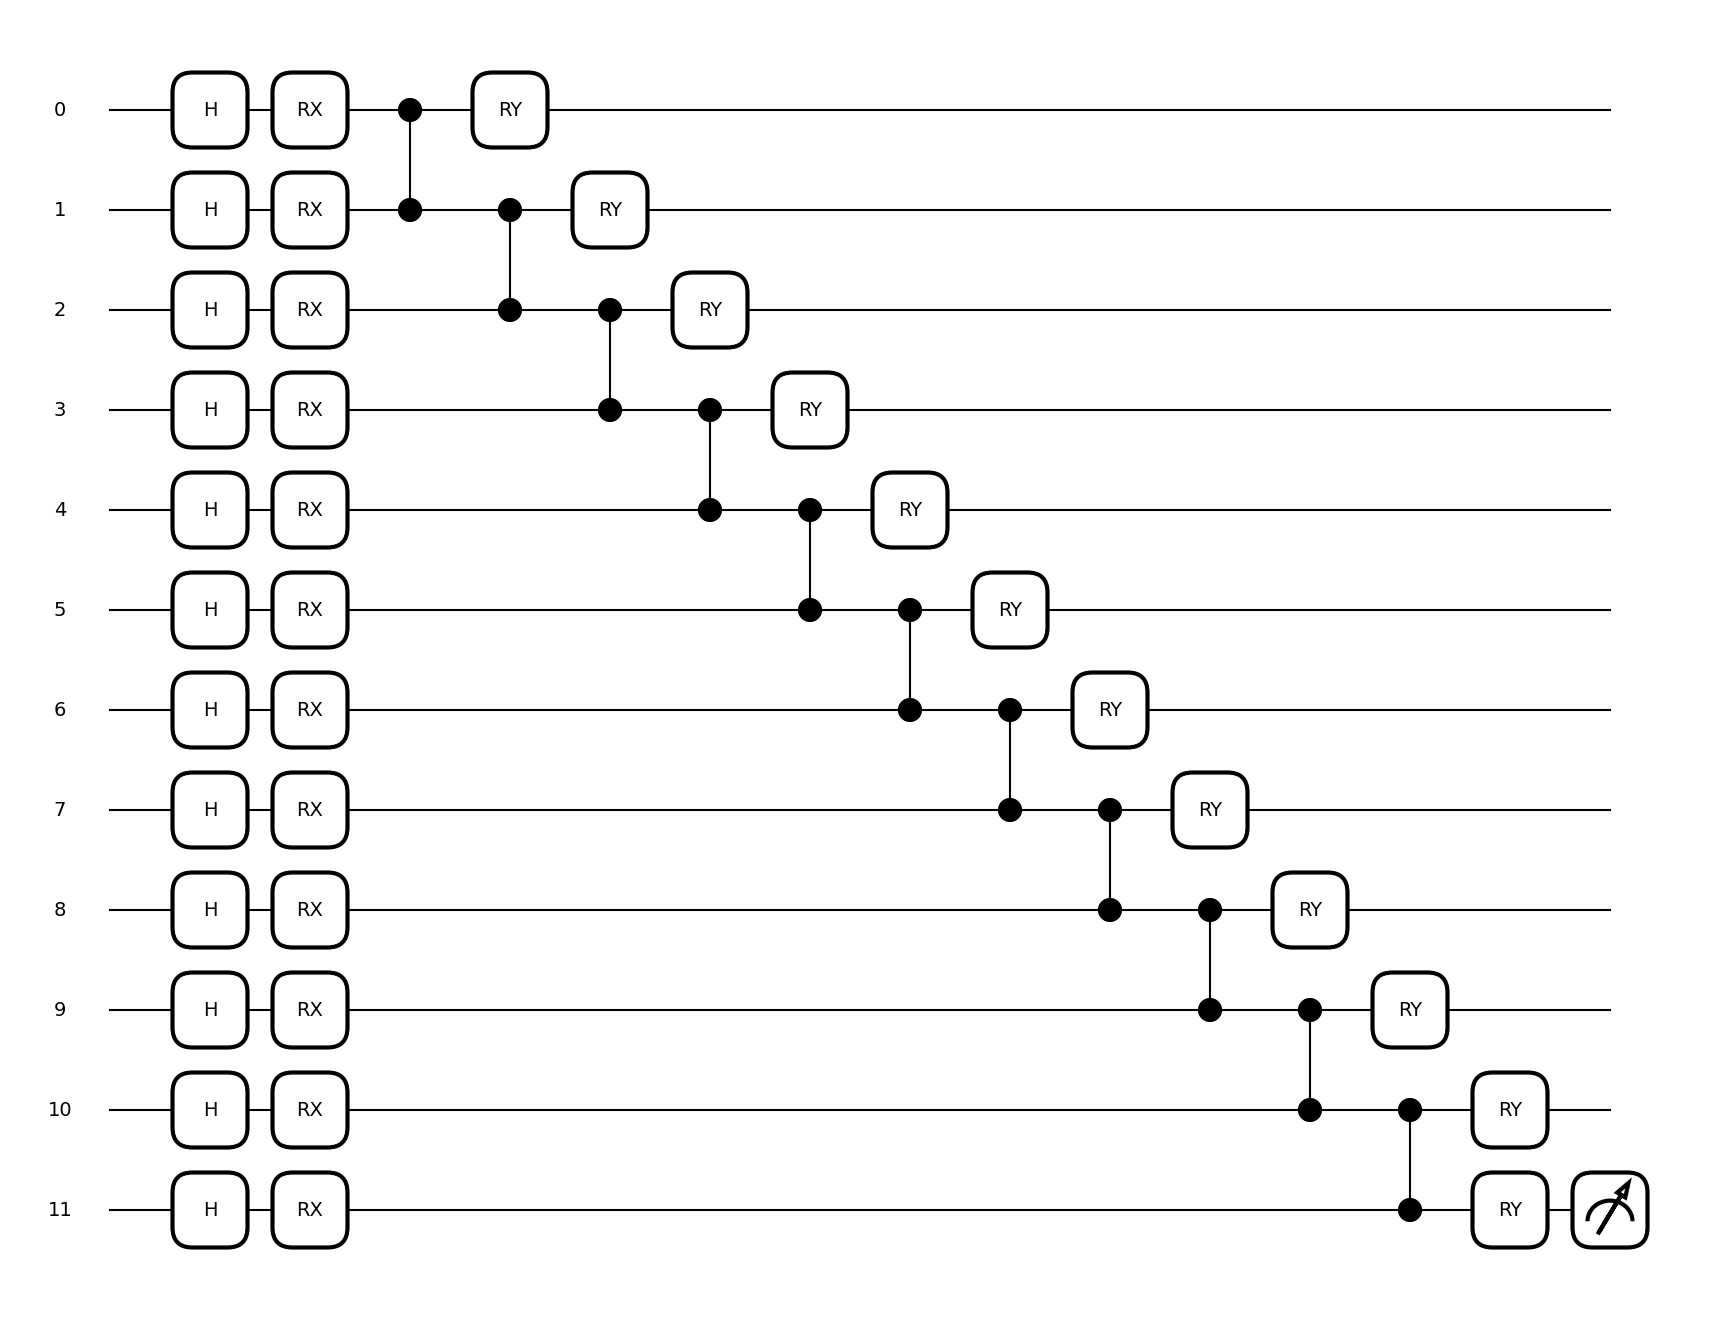

In [5]:
qml.draw_mpl(actor_qnode)(np.ones(n_qubits), np.ones(n_qubits), np.ones(n_qubits))
#qml.draw(actor_qnode)(n_qubits, np.ones(n_qubits), np.ones(n_qubits), np.ones(n_qubits))

(<Figure size 2200x1800 with 1 Axes>, <Axes: >)

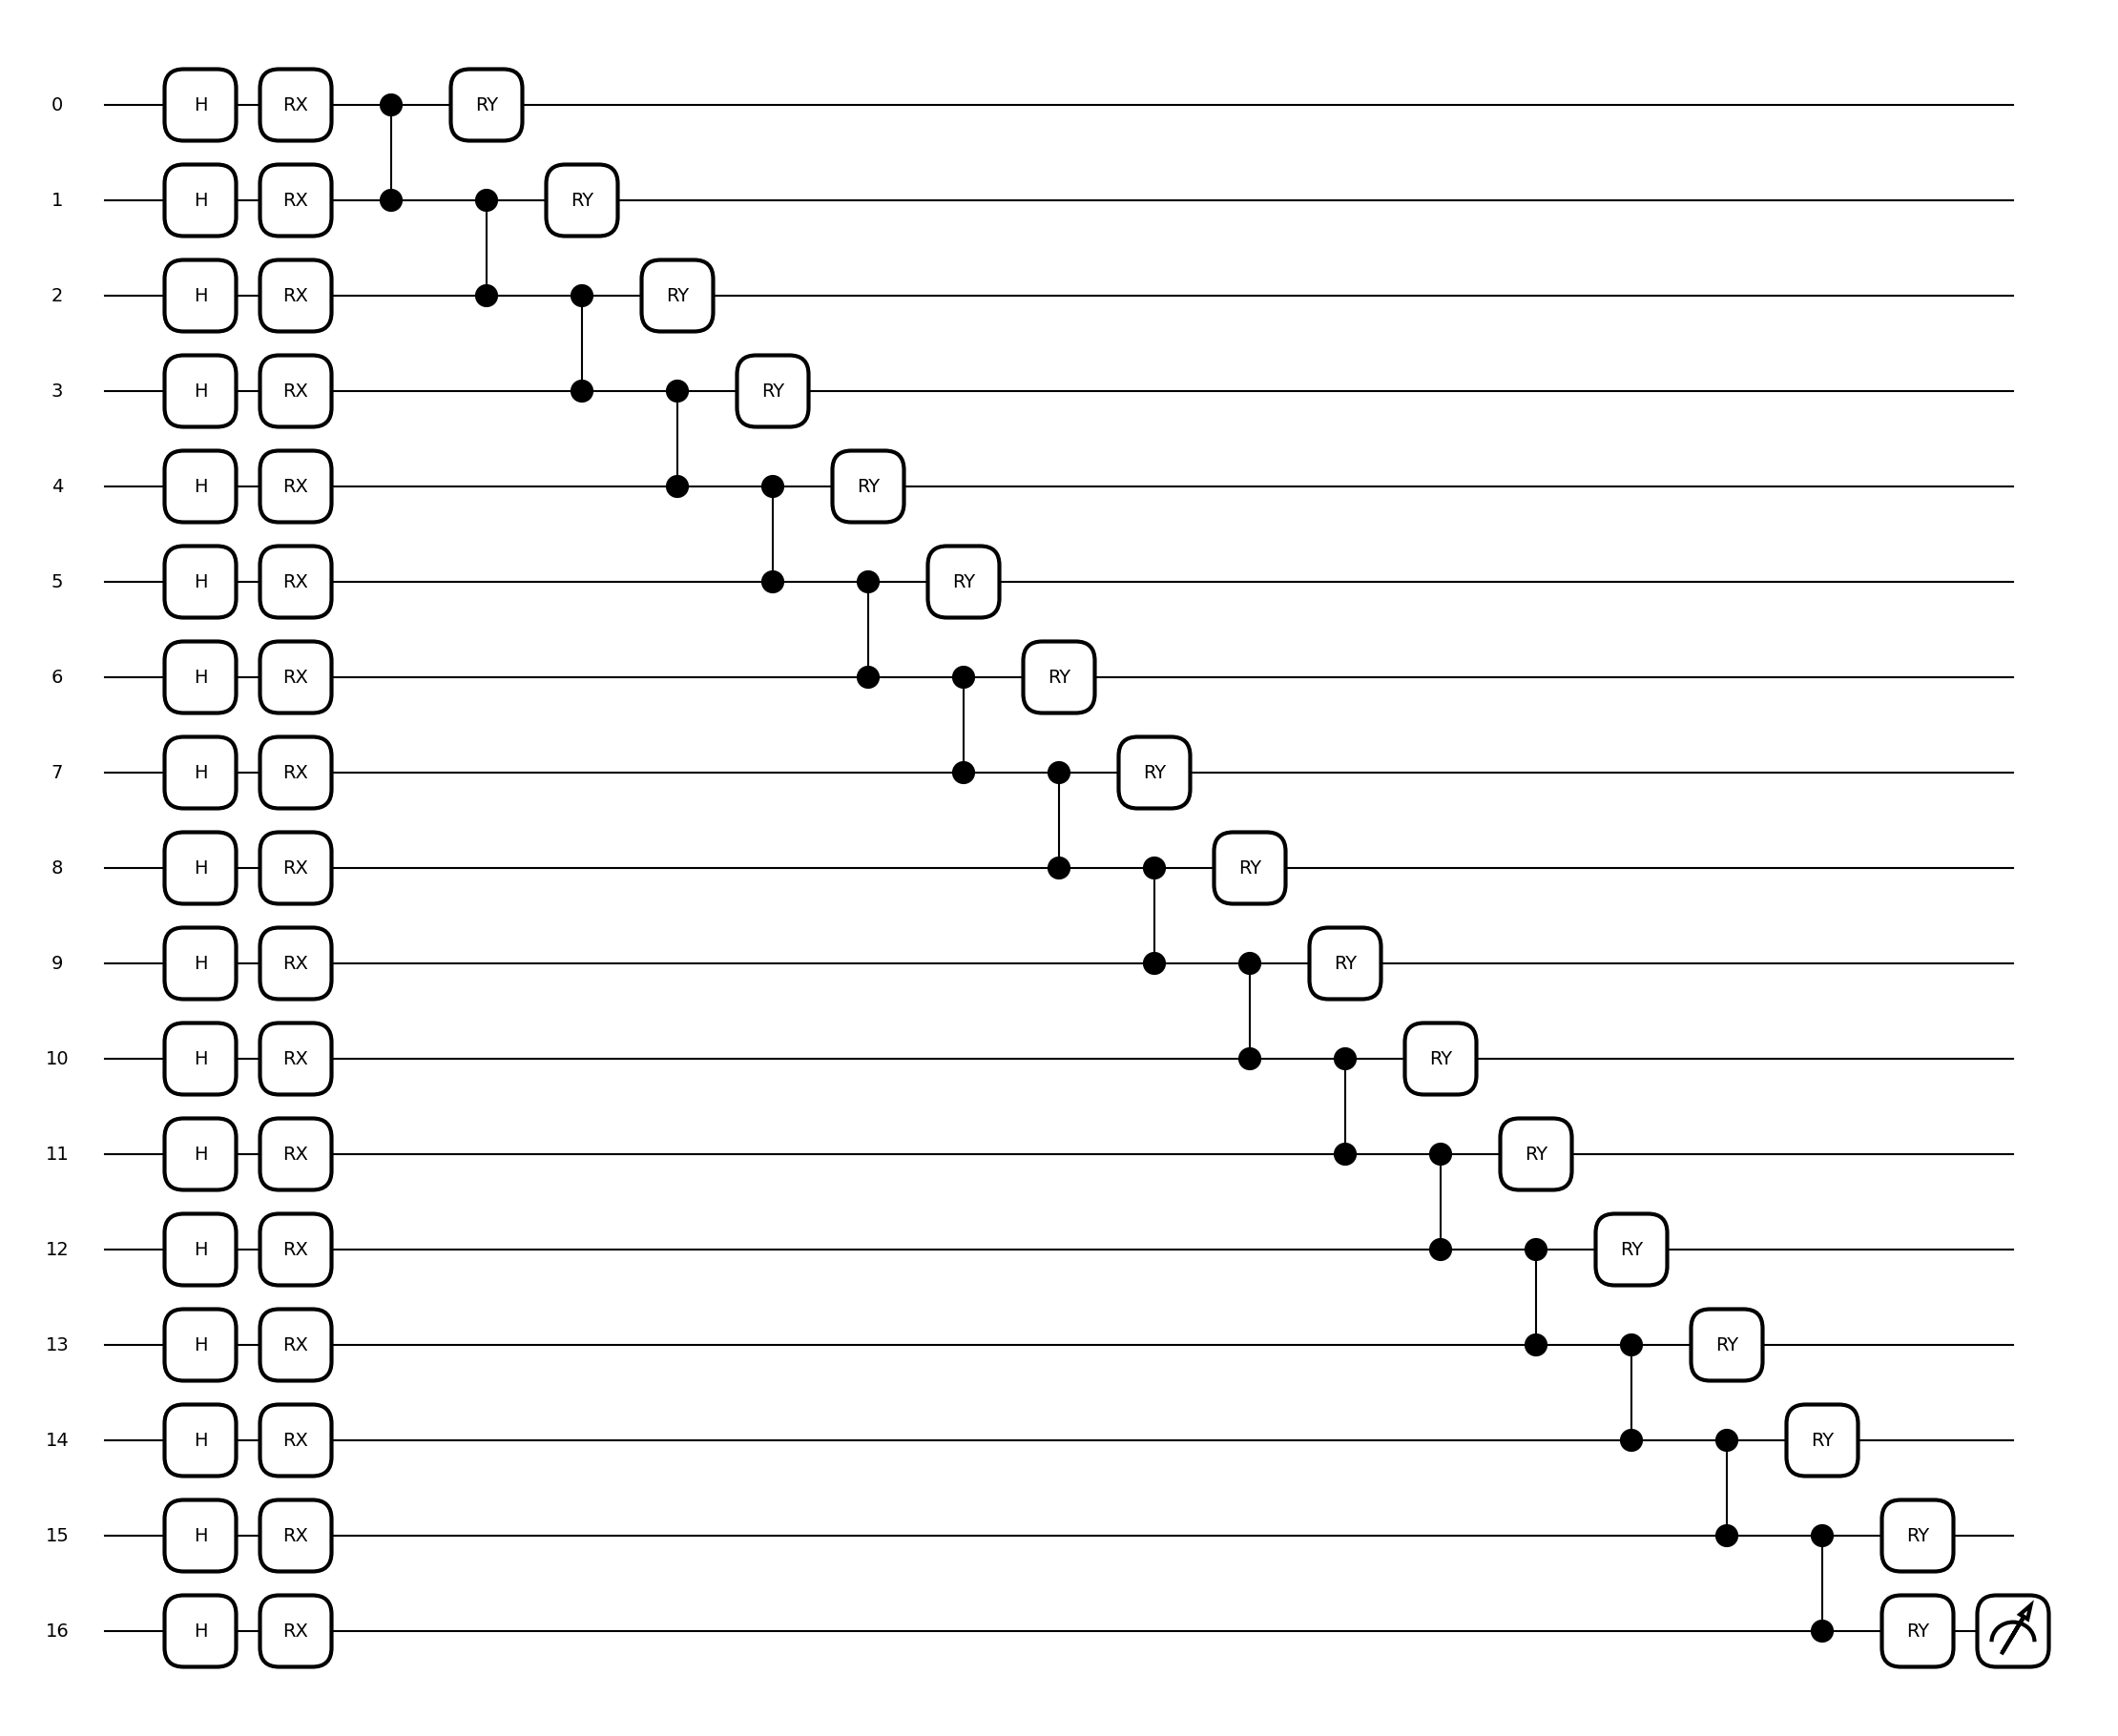

In [6]:
qml.draw_mpl(critic_qnode)(np.ones(n_crit_qubits), np.ones(n_crit_qubits), np.ones(n_crit_qubits))

In [4]:
actor_grad_fn = qml.grad(actor_qnode, argnum=2)
grad_vals = actor_grad_fn(actor_inp_vec, theta, theta_par)
print(grad_vals)

[-7.60569785e-19 -3.11482160e-18 -6.97557207e-19 -8.58990915e-19
 -9.83860095e-19 -8.48520347e-18 -4.62225150e-19 -1.86031729e-18
  7.62954659e-19  1.47986126e-18  1.53169624e-16  8.68379454e-16]


In [5]:
critic_grad_fn = qml.grad(critic_qnode, argnum=2)
grad_vals = critic_grad_fn(full_input, crit_theta, crit_theta_par)
print(grad_vals)

[ 1.32477750e-19  4.55907210e-19 -5.39133518e-19  3.60246274e-19
  2.02301562e-18 -1.32428499e-20 -1.29978734e-18 -6.11851547e-19
 -4.35873108e-19 -9.05842083e-19 -5.73309512e-19  9.58504911e-19
 -2.48842931e-19  1.23305421e-18  4.88507856e-19  4.85252118e-18
  2.65650068e-18]


In [6]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
for _ in range(10):
    theta_par, loss = opt.step_and_cost(lambda tp: -critic_qnode(full_input, crit_theta, tp), crit_theta_par)
    print("Loss:", loss)

Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15
Loss: 5.10702591327572e-15


In [ ]:
# TODO: Implement updating the theta parameter for the RY gates 
# TODO: Implement updating the x input data vector for the RX gates based on the values stored in the Memory Experience Relay
#num_eps = 10
#for i in range(num_eps):
    

In [ ]:
# Function to take the rewards and updated observation state space and output s' (new state)
# Returns the input current observation state, the action taken by the agent, the reward given by the action and the updated state
# State s should be passed to the actor ansatz
# State s and action a should be passed to the critic ansatz
def mem_exp_replay_buffer(state, action, rewards):
    new_state = state

In [24]:
def decode_op(q_values, method="mean"):
    if method == "mean":
        return np.mean(q_values)
    elif method == "sum":
        return np.sum(q_values)
    elif method == "weighted":
        weights = np.linspace(1, 0.5, len(q_values))
        return np.dot(weights, q_values)
    else:
        raise ValueError("Unknown decoding method")

In [3]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [29]:
%load_ext autoreload
%autoreload 2
from uav_lqdrl_env import UAV_LQDRL_Environment
from quantum_models import QuantumActor, QuantumCritic
from replay_buffer import ReplayBuffer
from pennylane.optimize import AdamOptimizer

env = UAV_LQDRL_Environment()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor = QuantumActor(n_qubits=state_dim, m_layers=3)
critic = QuantumCritic(n_qubits=state_dim + action_dim, m_layers=3)

buffer = ReplayBuffer()
actor_opt = AdamOptimizer(stepsize=0.01)
critic_opt = AdamOptimizer(stepsize=0.01)

episodes = 20
batch_size = 6
gamma = 0.99

tot_reward_arr = []
actor_losses = []
critic_losses = []

for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    ep_uav_trajectory = []

    while not done:
        state_tensor = np.array(state, requires_grad=False)
        action = actor(state_tensor)
        action = np.clip(np.array(action), -1, 1)

        next_state, reward, done, _, _ = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state

        if len(buffer) >= batch_size:
            batch = buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

            def critic_loss(theta):
                critic.update_params(theta)
                loss = 0
                for s, a, r, ns, d in zip(states, actions, rewards, next_states, dones):
                    sa = np.concatenate([s, a])
                    q_val = critic(sa)
                    q_val = critic.decode_op(q_val)
                    print("Critic Q-Value: ", q_val)

                    na = actor(ns)
                    nsa = np.concatenate([ns, na])
                    q_val_next = critic(nsa)
                    q_val_next = critic.decode_op(q_val_next)

                    target = r + gamma * q_val_next * (1 - d)
                    print("Critic Target: ", target)
                    loss += (q_val - target) ** 2
                return loss / batch_size

            critic.theta, critic_loss_val = critic_opt.step_and_cost(critic_loss, critic.theta)
            critic_losses.append(critic_loss_val)

            def actor_loss(theta):
                actor.update_params(theta)
                loss = 0
                for s in states:
                    a = actor(s)
                    sa = np.concatenate([s, a])
                    q_val = critic(sa)
                    q_val = critic.decode_op(q_val)
                    print("Actor Q-Value: ", q_val)
                    loss -= q_val
                return loss / batch_size

            actor.theta, actor_loss_val = actor_opt.step_and_cost(actor_loss, actor.theta)
            actor_losses.append(actor_loss_val)

    tot_reward_arr.append(total_reward)
    print(f"Episode {ep} | Total reward: {total_reward:.2f}")

print("All good so far")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 0 | Total reward: 20.56
Episode 1 | Total reward: 19.93
Episode 2 | Total reward: 35.61
Episode 3 | Total reward: 25.75
Episode 4 | Total reward: 38.31
Critic Q-Value:  Autograd ArrayBox with value 2.3937583811051573
Critic Target:  Autograd ArrayBox with value 38.30687691183959
Critic Q-Value:  Autograd ArrayBox with value 1.4606492150895711
Critic Target:  Autograd ArrayBox with value 35.61168103578369
Critic Q-Value:  Autograd ArrayBox with value 1.2578643791593787
Critic Target:  Autograd ArrayBox with value 19.93400901832927
Critic Q-Value:  Autograd ArrayBox with value 0.9668651925931547
Critic Target:  Autograd ArrayBox with value 25.751608124993204
Critic Q-Value:  Autograd ArrayBox with value 2.0557039052903305
Critic Target:  Autograd ArrayBox with value 29.203110351313207
Critic Q-Value:  Autograd ArrayBox with value 2.6513636467359776
Critic Target:  Autograd ArrayBox with value 

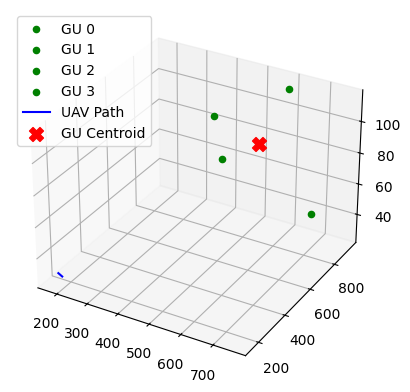

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for gu in env.legit_users:
    pos = gu.position
    ax.scatter(pos[0], pos[1], pos[2], label=f"GU {gu.id}", color="green")
 
centroid = np.mean([gu.position for gu in env.legit_users], axis=0)

uav_positions = np.array(env.uavs[0].history)
ax.plot(uav_positions[:,0], uav_positions[:,1], uav_positions[:,2], label="UAV Path", color="blue")

ax.scatter(*centroid, label="GU Centroid", color="red", marker="X", s=100)
plt.legend()
plt.show()

In [39]:
def evaluate_agent_histories(env, num_episodes=20):
    episode_rewards = []
    all_histories = []

    for ep in range(num_episodes):
        obs = env.reset()[0]
        done = False
        total_reward = 0
        uav_histories = [[] for _ in env.uavs]

        while not done:
            for i, uav in enumerate(env.uavs):
                uav_histories[i].append(uav.position.copy())

        all_histories.append(uav_histories)

    return all_histories

In [40]:
def render_trajectories(histories, env):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(histories[0])):  # Number of UAVs
        traj = np.array([ep[i][-1] for ep in histories])
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"UAV-{i}")
        ax.scatter(traj[-1, 0], traj[-1, 1], traj[-1, 2], marker='o')

    for gu in env.legit_users:
        ax.scatter(gu.position[0], gu.position[1], gu.position[2], color='red', marker='x', s=60, label=f'GU {gu.id}') 

    ax.set_title("UAV Trajectories (Final Positions Across Episodes)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

In [38]:
histories = evaluate_agent_histories(env, num_episodes=20)

NameError: name 'model' is not defined

In [19]:
%load_ext autoreload
%autoreload 2
from uav_lqdrl_env import UAV_LQDRL_Environment
from quantum_models import QuantumActor, QuantumCritic
from replay_buffer import ReplayBuffer
from pennylane.optimize import AdamOptimizer

env = UAV_LQDRL_Environment()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor = QuantumActor(n_qubits=state_dim, m_layers=3)
critic = QuantumCritic(n_qubits=state_dim + action_dim, m_layers=3)

buffer = ReplayBuffer()
actor_opt = AdamOptimizer(stepsize=0.01)
critic_opt = AdamOptimizer(stepsize=0.01)

episodes = 5
batch_size = 1
gamma = 0.99

tot_reward_arr = []
actor_losses = []
critic_losses = []

for ep in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = np.array(state, requires_grad=False)
        action = actor(state_tensor)
        action = np.clip(np.array(action), -1, 1)

        next_state, reward, done, _, _ = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state

        if len(buffer) >= batch_size:
            batch = buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

            def critic_loss(theta):
                critic.update_params(theta)
                loss = 0
                for s, a, r, ns, d in zip(states, actions, rewards, next_states, dones):
                    sa = np.concatenate([s, a])
                    q_val = critic(sa)
                    q_val = critic.decode_op(q_val)
                    print("Critic Q-Value: ", q_val)

                    na = actor(ns)
                    nsa = np.concatenate([ns, na])
                    q_val_next = critic(nsa)
                    q_val_next = critic.decode_op(q_val_next)

                    target = r + gamma * q_val_next * (1 - d)
                    print("Critic Target: ", target)
                    loss += (q_val - target) ** 2
                return loss / batch_size

            critic.theta, critic_loss_val = critic_opt.step_and_cost(critic_loss, critic.theta)
            critic_losses.append(critic_loss_val)

            def actor_loss(theta):
                actor.update_params(theta)
                loss = 0
                for s in states:
                    a = actor(s)
                    sa = np.concatenate([s, a])
                    q_val = critic(sa)
                    q_val = critic.decode_op(q_val)
                    print("Actor Q-Value: ", q_val)
                    loss -= q_val
                return loss / batch_size

            actor.theta, actor_loss_val = actor_opt.step_and_cost(actor_loss, actor.theta)
            actor_losses.append(actor_loss_val)

    tot_reward_arr.append(total_reward)
    print(f"Episode {ep} | Total reward: {total_reward:.2f}")

print("All good so far")

Critic Q-Value:  Autograd ArrayBox with value -0.01214781531137025
Actor Q-Value:  Autograd ArrayBox with value -0.008544313482594986
Episode 0 | Total reward: 28.47
Critic Q-Value:  Autograd ArrayBox with value -0.008544313482594986
Actor Q-Value:  Autograd ArrayBox with value -0.004864460066066837
Episode 1 | Total reward: 47.98
Critic Q-Value:  Autograd ArrayBox with value -0.0049126778295894066
Actor Q-Value:  Autograd ArrayBox with value -0.0011596465755057063
Episode 2 | Total reward: 41.43
Critic Q-Value:  Autograd ArrayBox with value -0.01658959237151212
Actor Q-Value:  Autograd ArrayBox with value -0.013539181527262516
Episode 3 | Total reward: 24.98
Critic Q-Value:  Autograd ArrayBox with value -0.013550674328129522
Actor Q-Value:  Autograd ArrayBox with value -0.010281291664116163
Episode 4 | Total reward: 15.70
All good so far


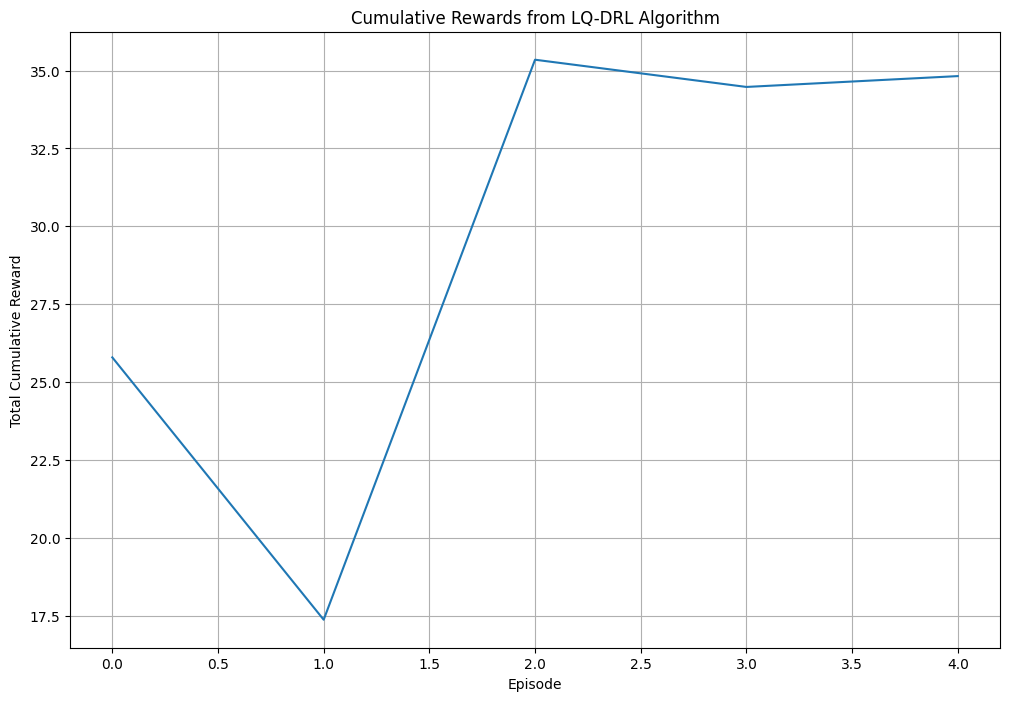

In [17]:
plt.figure(figsize=(12, 8))
eps_arr = np.arange(0, episodes, 1)
plt.plot(eps_arr, tot_reward_arr)
plt.xlabel('Episode')
plt.ylabel('Total Cumulative Reward')
plt.grid()
plt.title('Cumulative Rewards from LQ-DRL Algorithm')
plt.show()

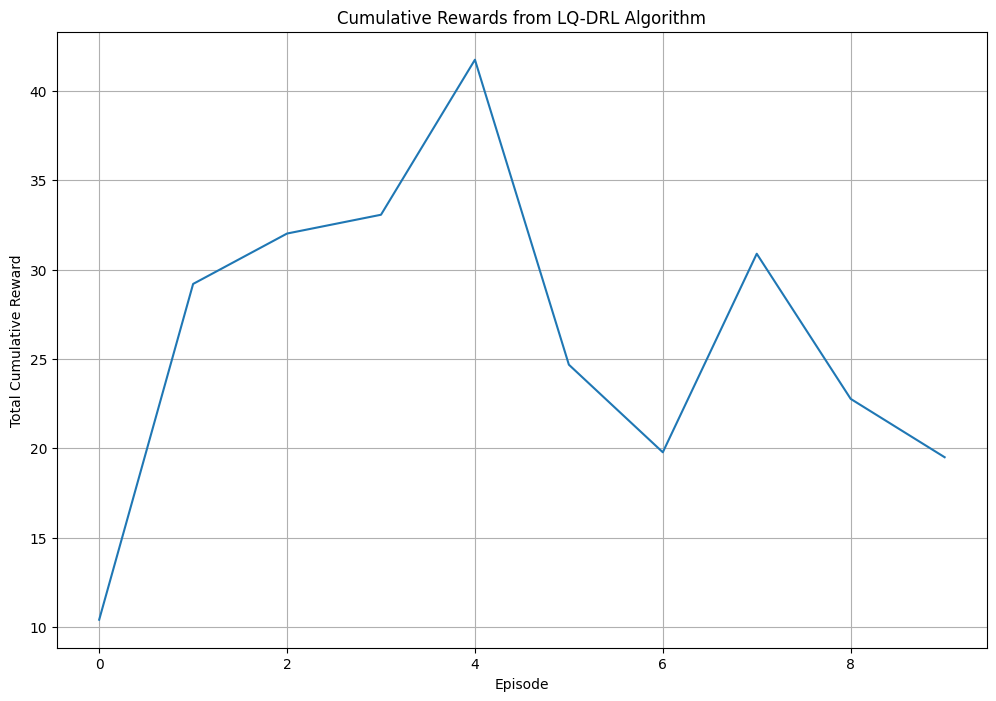

In [11]:
plt.figure(figsize=(12, 8))
eps_arr = np.arange(0, episodes, 1)
plt.plot(eps_arr, tot_reward_arr)
plt.xlabel('Episode')
plt.ylabel('Total Cumulative Reward')
plt.grid()
plt.title('Cumulative Rewards from LQ-DRL Algorithm')
plt.show()

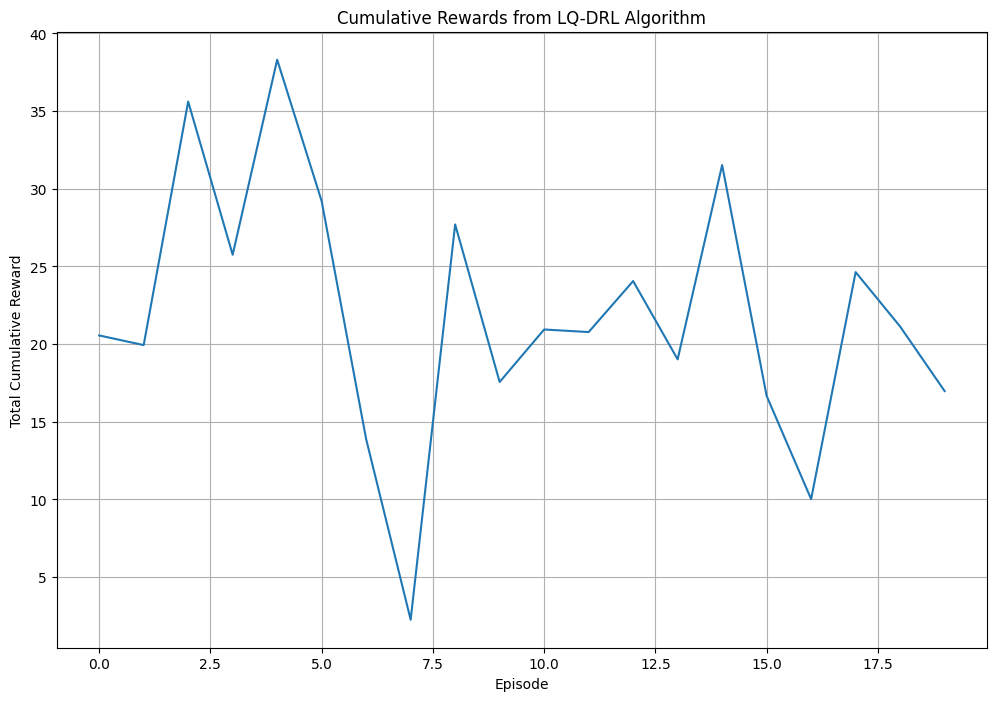

In [30]:
plt.figure(figsize=(12, 8))
eps_arr = np.arange(0, episodes, 1)
plt.plot(eps_arr, tot_reward_arr)
plt.xlabel('Episode')
plt.ylabel('Total Cumulative Reward')
plt.grid()
plt.title('Cumulative Rewards from LQ-DRL Algorithm')
plt.show()

In [9]:
print(critic_losses)
print("============")
print(actor_losses)

[tensor(595.56271397, requires_grad=True), tensor(595.34662467, requires_grad=True), tensor(294.73152636, requires_grad=True), tensor(505.10288813, requires_grad=True), tensor(787.70401652, requires_grad=True), tensor(1125.44942541, requires_grad=True), tensor(521.57111331, requires_grad=True), tensor(365.03295413, requires_grad=True)]
[0.0047937609624365525, -0.00022165161911437428, -0.01800543902609669, -0.031224297337886727, -0.042078280373782556, -0.04655996004563407, -0.04408045708383829, -0.03142204112170363]


(<Figure size 2500x1300 with 1 Axes>, <Axes: >)

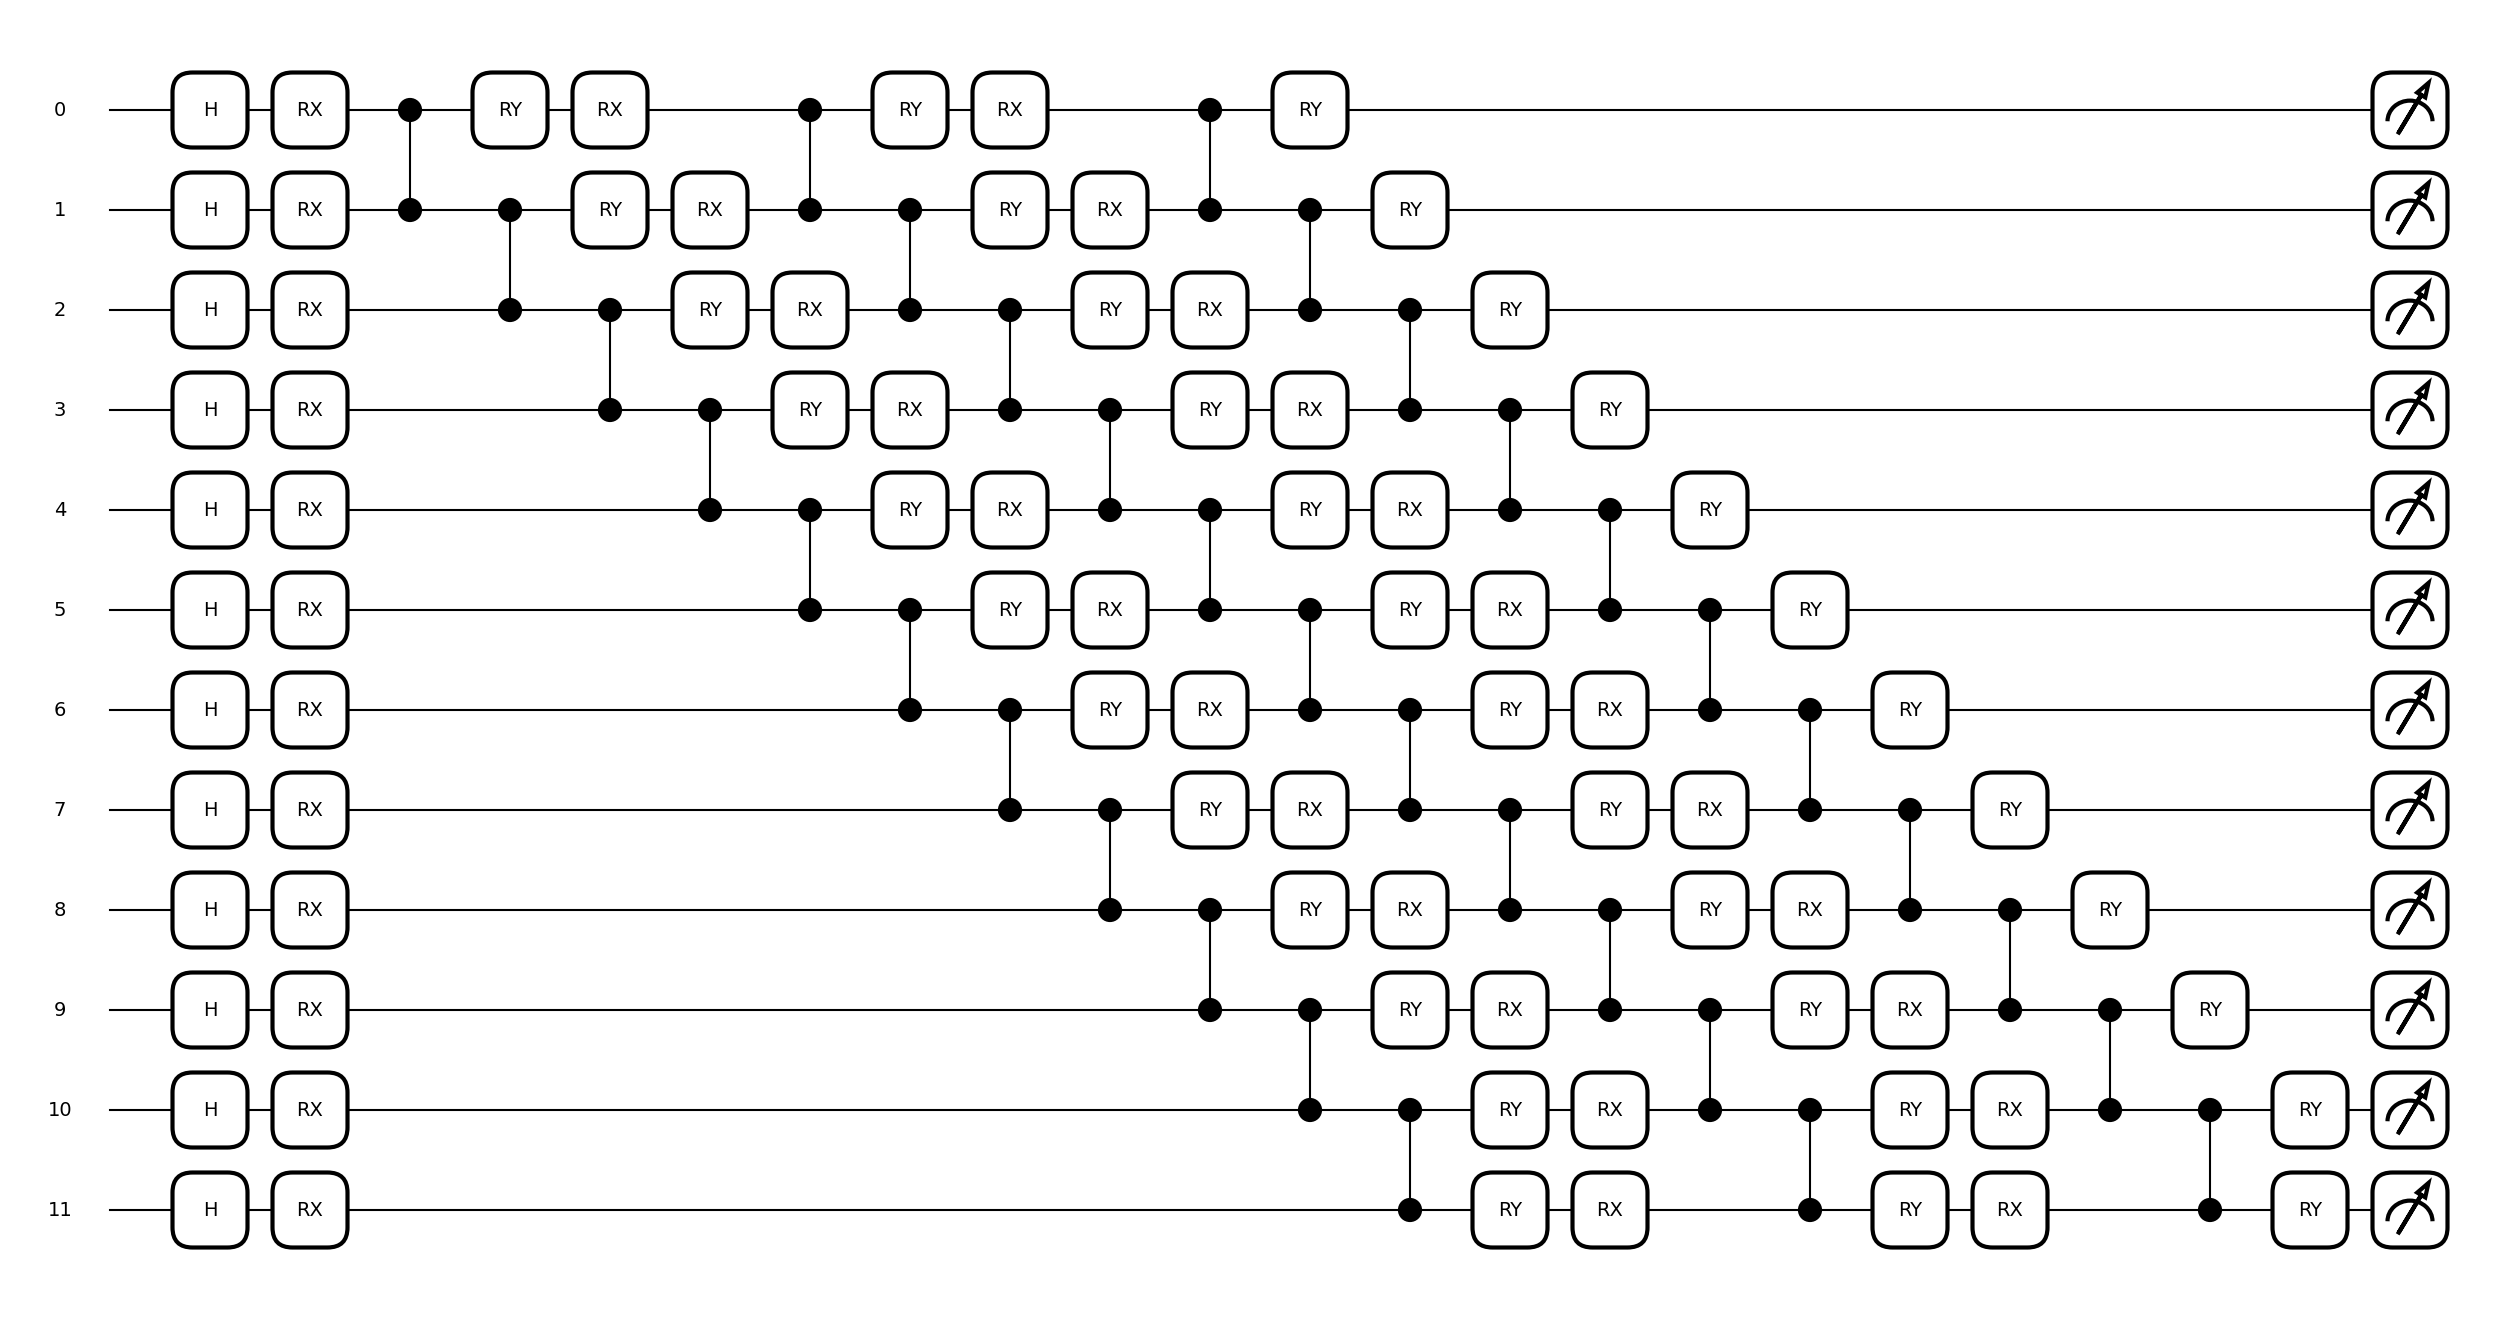

In [23]:
actor.latex(state_tensor)

(<Figure size 3000x1800 with 1 Axes>, <Axes: >)

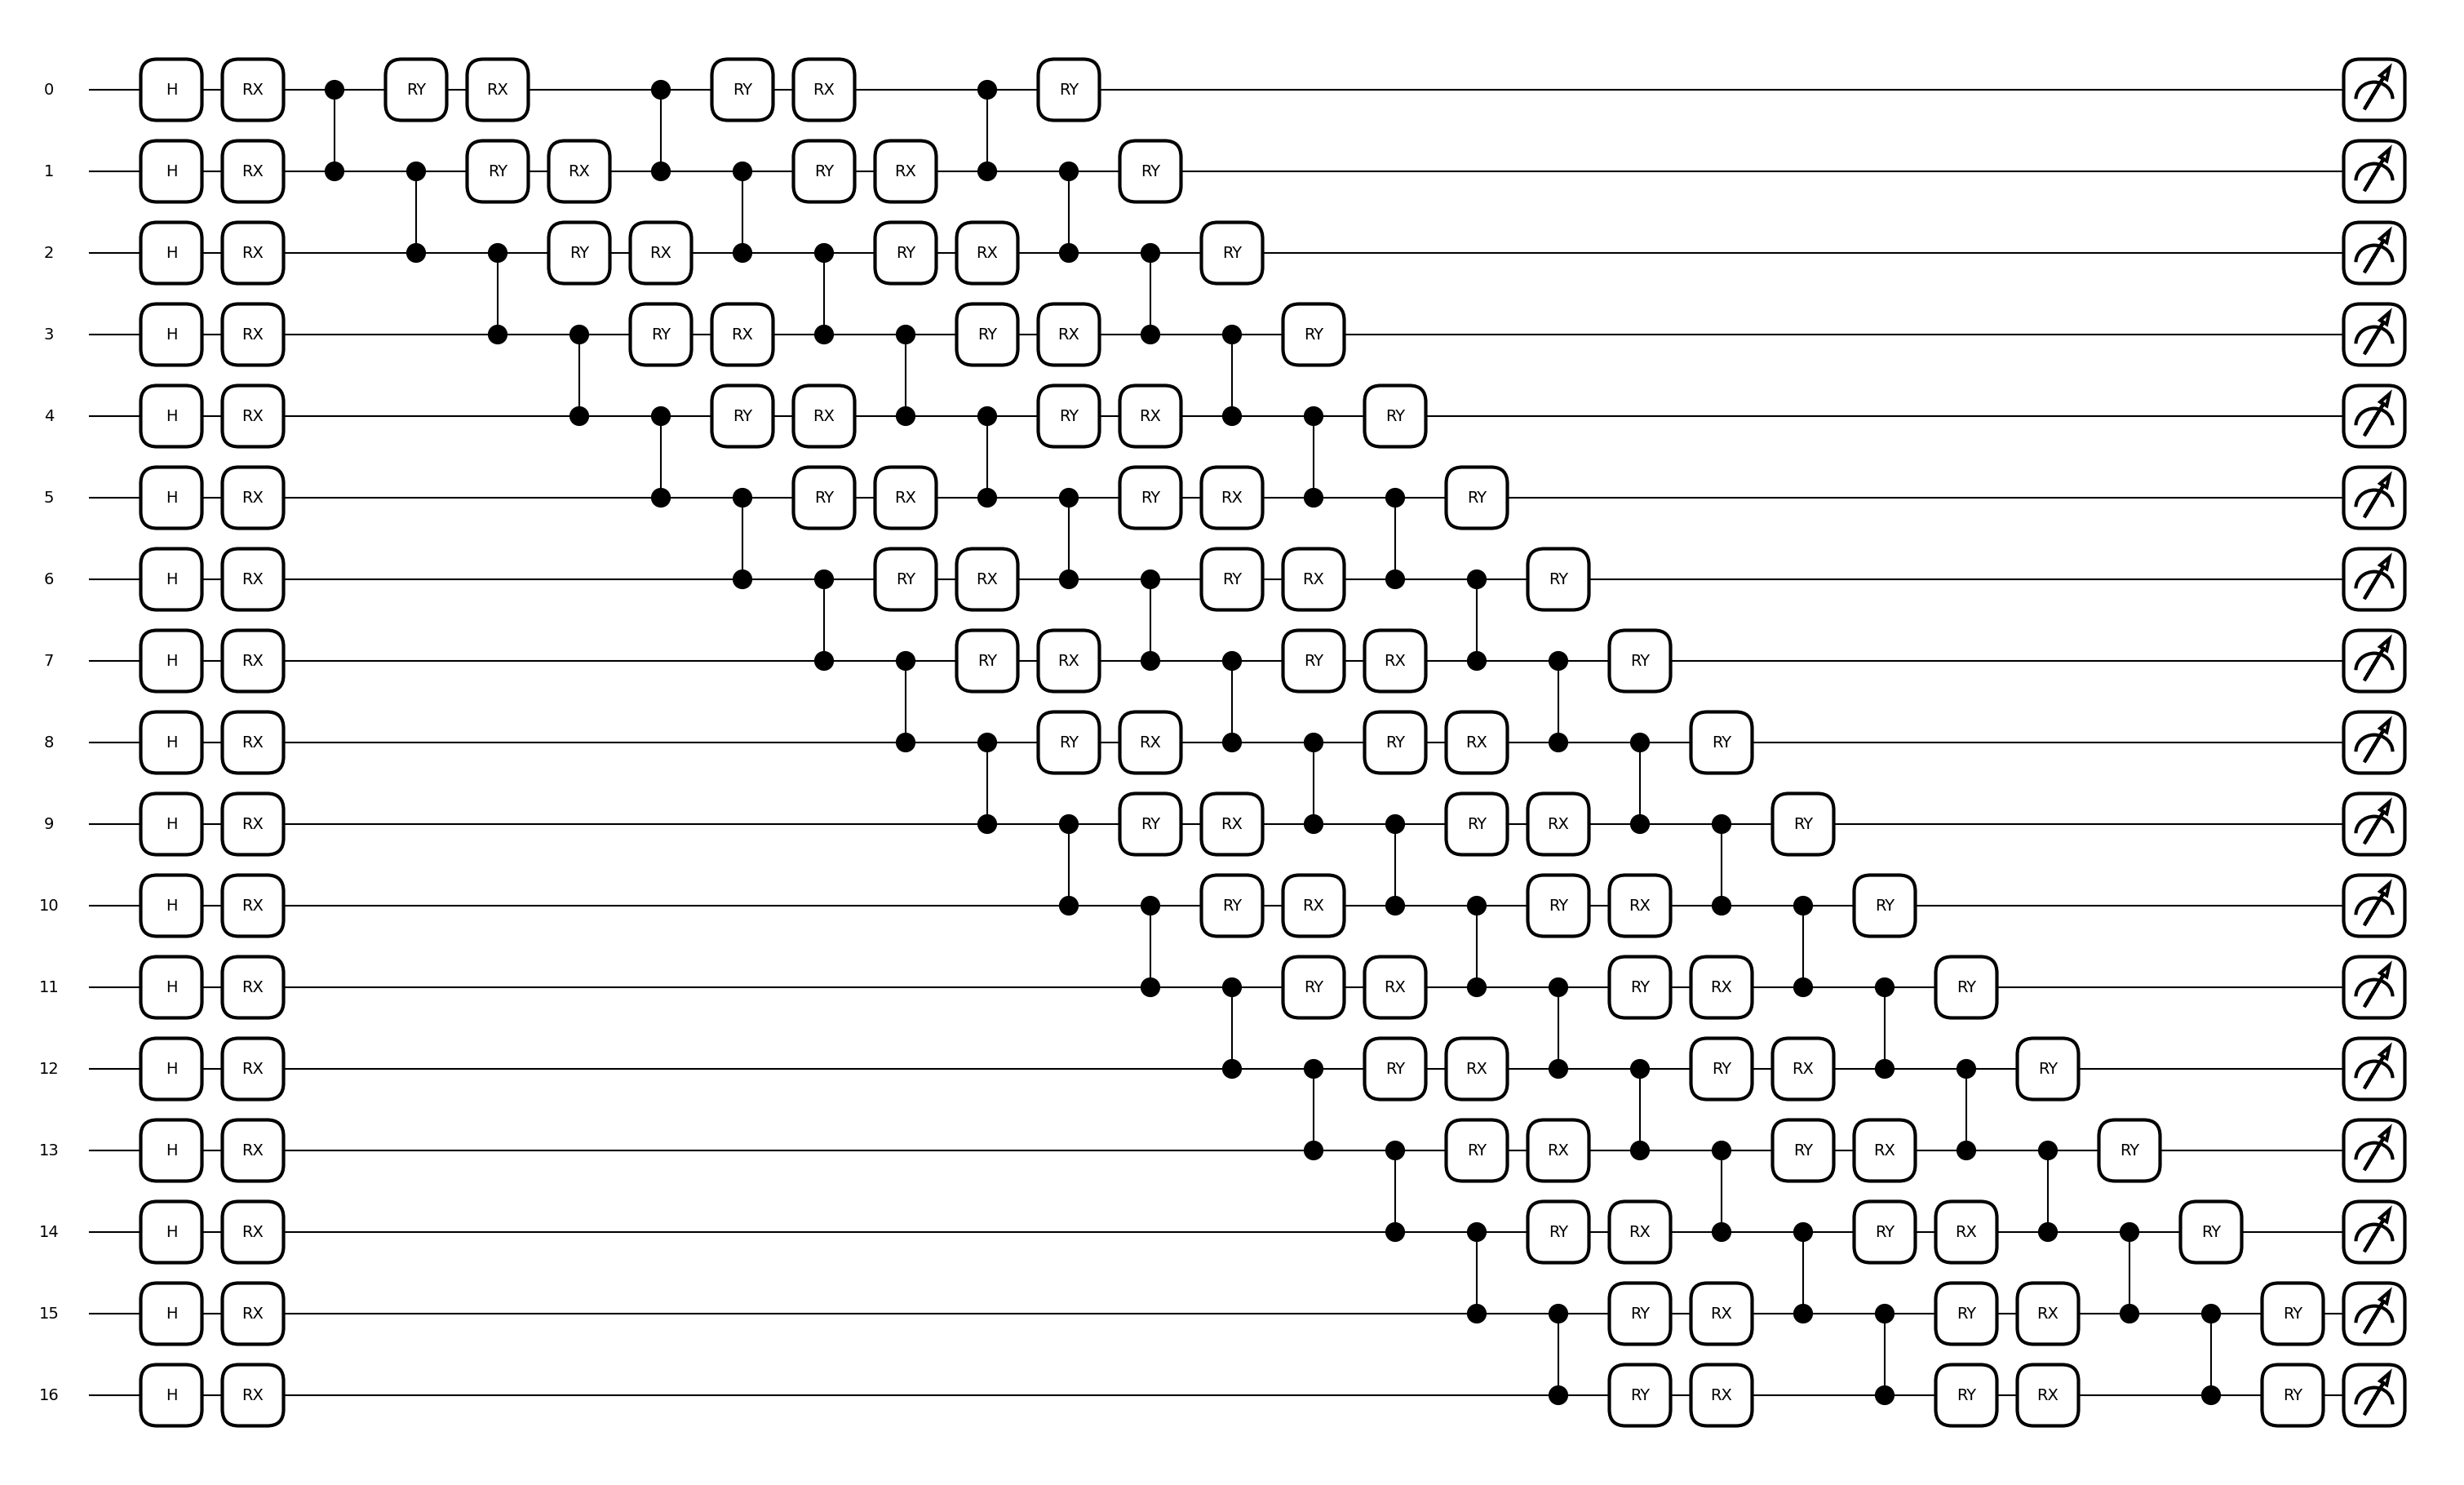

In [24]:
crit_state_action = np.concatenate([state, action])
critic.latex(crit_state_action)

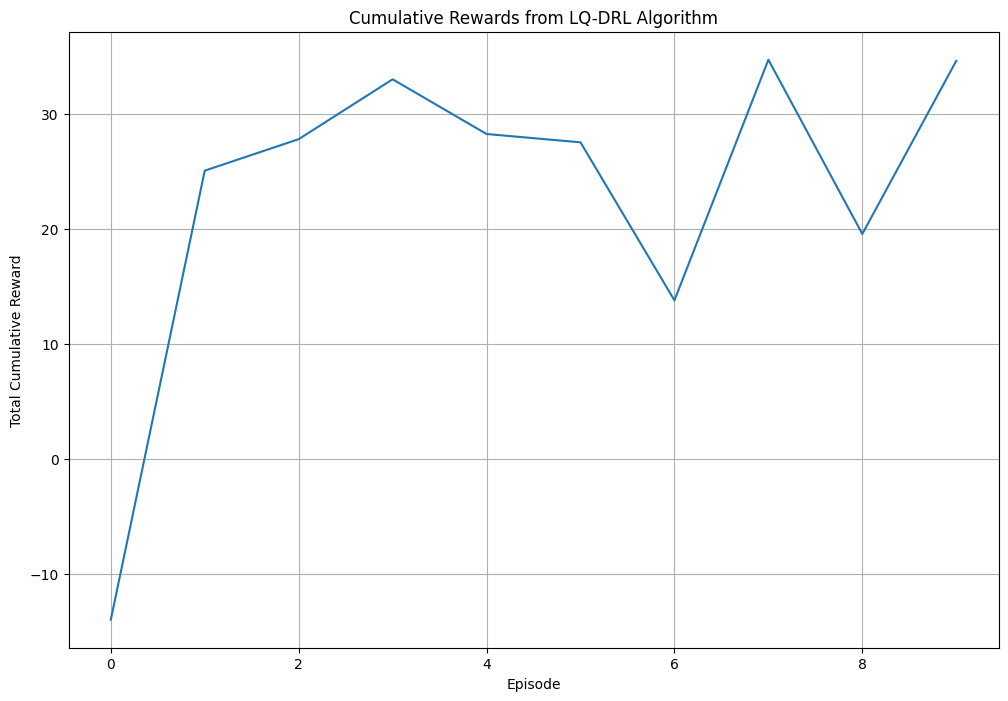

In [7]:
plt.figure(figsize=(12, 8))
eps_arr = np.arange(0, episodes, 1)
plt.plot(eps_arr, tot_reward_arr)
plt.xlabel('Episode')
plt.ylabel('Total Cumulative Reward')
plt.grid()
plt.title('Cumulative Rewards from LQ-DRL Algorithm')
plt.show()

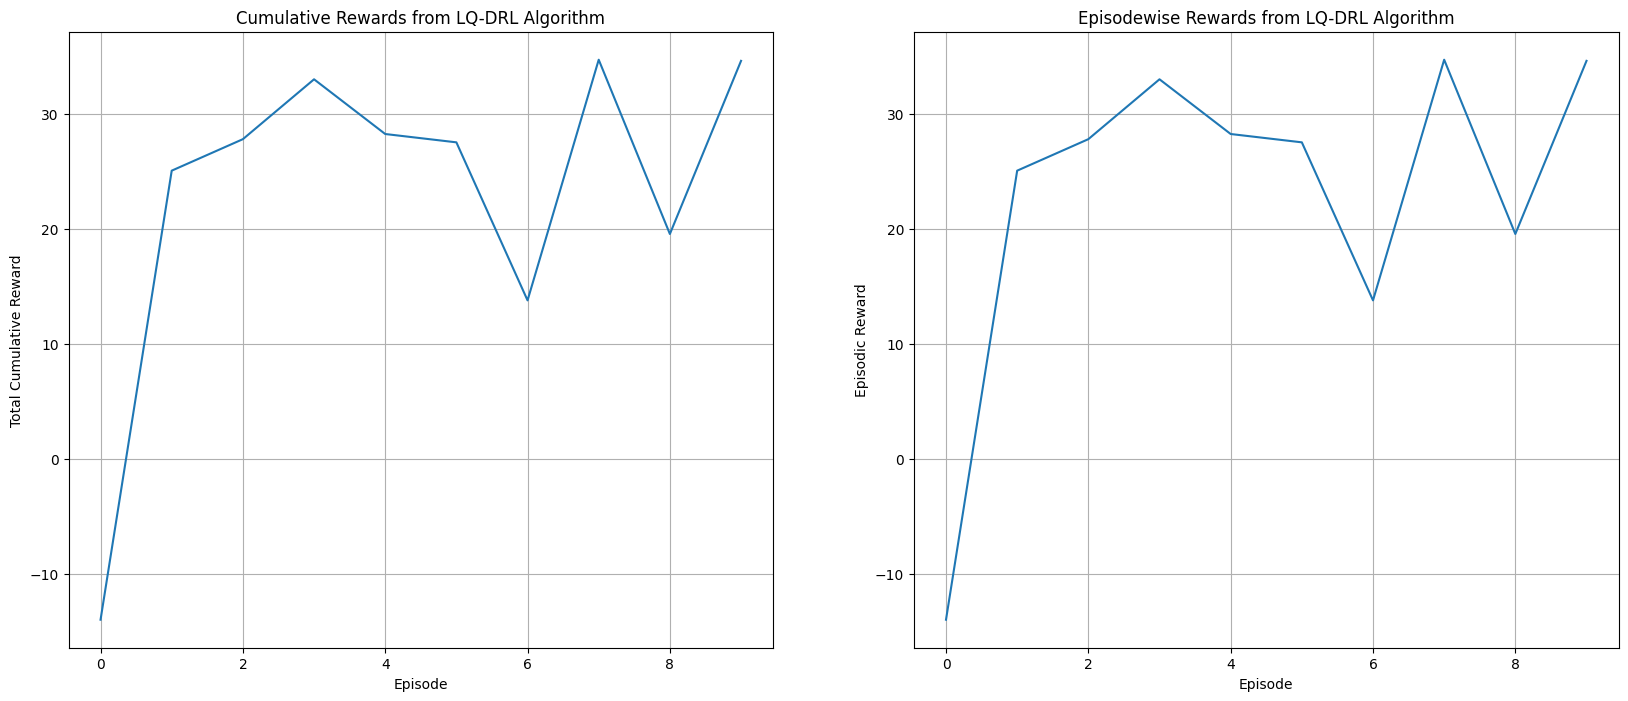

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
eps_arr = np.arange(0, episodes, 1)
ax[0].plot(eps_arr, tot_reward_arr)
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Total Cumulative Reward')
ax[0].grid()
ax[0].set_title('Cumulative Rewards from LQ-DRL Algorithm')

ax[1].plot(eps_arr, reward_arr)
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Episodic Reward')
ax[1].grid()
ax[1].set_title('Episodewise Rewards from LQ-DRL Algorithm')

plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

In [38]:
print(np.tanh(np.pi))

0.19925441524414997


(<Figure size 3000x1800 with 1 Axes>, <Axes: >)


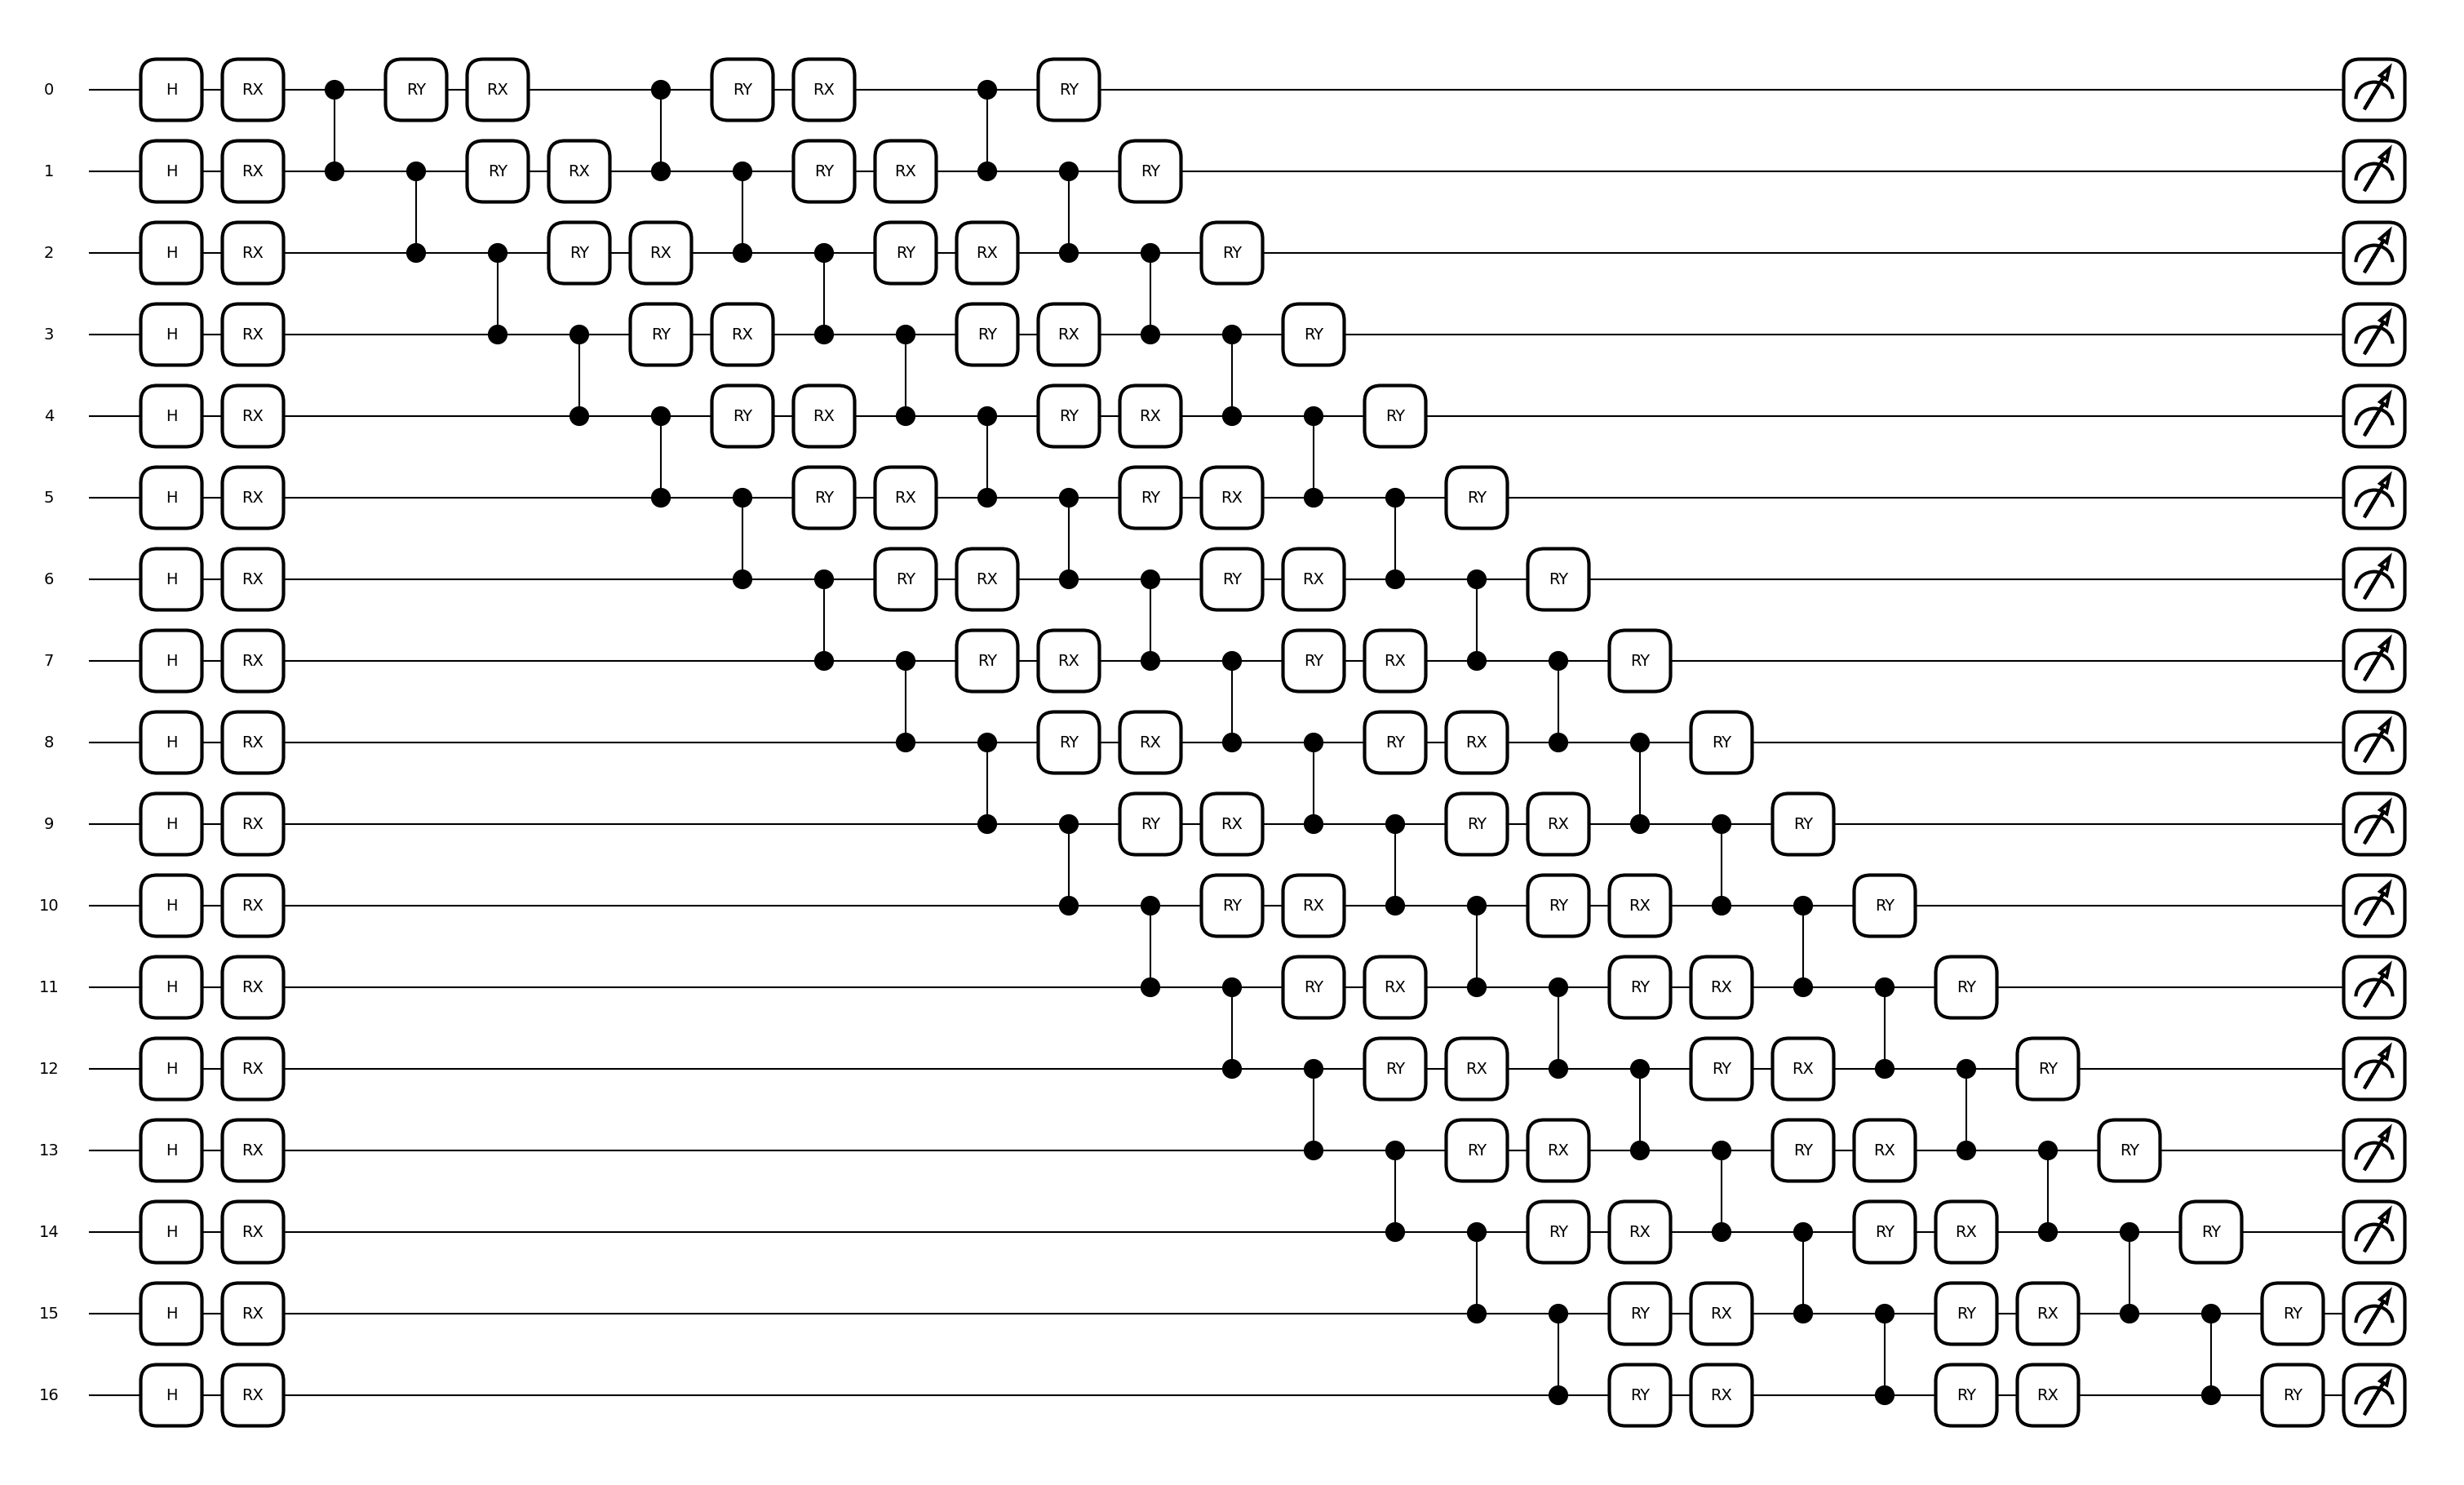

In [26]:
qml.drawer.use_style("black_white") 
drawer = qml.draw_mpl(critic.qnode)
n_qubits_critic = 17
print(drawer(np.random.randn(n_qubits_critic), critic.theta))